## Interpretability & Insights

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from interpretability import * 

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

import joblib
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance



#### Data Loading

In [2]:
df = pd.read_csv('../data/modelingData/modelingDataFrame.csv')

### XGBRegressor - Interpretation and Analysis of Results
Now, we will explore the interpretability of XGBRegressor, examining how feature importance contributes to predictions. By analyzing the most influential variables, we can gain insights into which factors drive model decisions and improve transparency. This process helps refine feature selection, optimize model performance, and identify potential biases affecting predictions.

In [ ]:
df = pd.read_csv('../data/modelingData/modelingDataFrame.csv')
event_names = ['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood','Winter Weather', 
               'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
               'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow', 'Ice Storm', 
               'Thunderstorm Wind', 'Avalanche', 'Excessive Heat', 'Coastal Flood', 'Storm Surge/Tide', 
               'Sleet', 'Debris Flow', 'Winter Storm', 'Tropical Storm', 'Dust Storm', 'Drought', 
               'Blizzard', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat', 'Freezing Fog', 
               'High Surf', 'High Wind']

df = df[df['ValidDataFlag'] == 1]
df.shape
zero_percentages = {}

for col in event_names:
    if col in df.columns:
        zero_count = (df[col] == 0).sum()
        total_count = len(df)
        zero_percentage = (zero_count / total_count) * 100
        zero_percentages[col] = zero_percentage

zero_percentages_df = pd.DataFrame.from_dict(zero_percentages, orient='index', columns=['%_zero'])
zero_percentages_df = zero_percentages_df.sort_values('%_zero', ascending=False)

selected_events_name = [
    col for col, perc in zero_percentages.items() if perc < 99.8
]

target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division', 'StateName']
event_features = [col for col in df.columns if col in selected_events_name]

X = df[numeric_features + categorical_features + event_features]

y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

event_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('event', event_transformer, event_features)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

pipeline.fit(X_train, y_train)

X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)

model = XGBRegressor(n_estimators=100, verbosity=1)
model.fit(X_train_transformed, y_train)


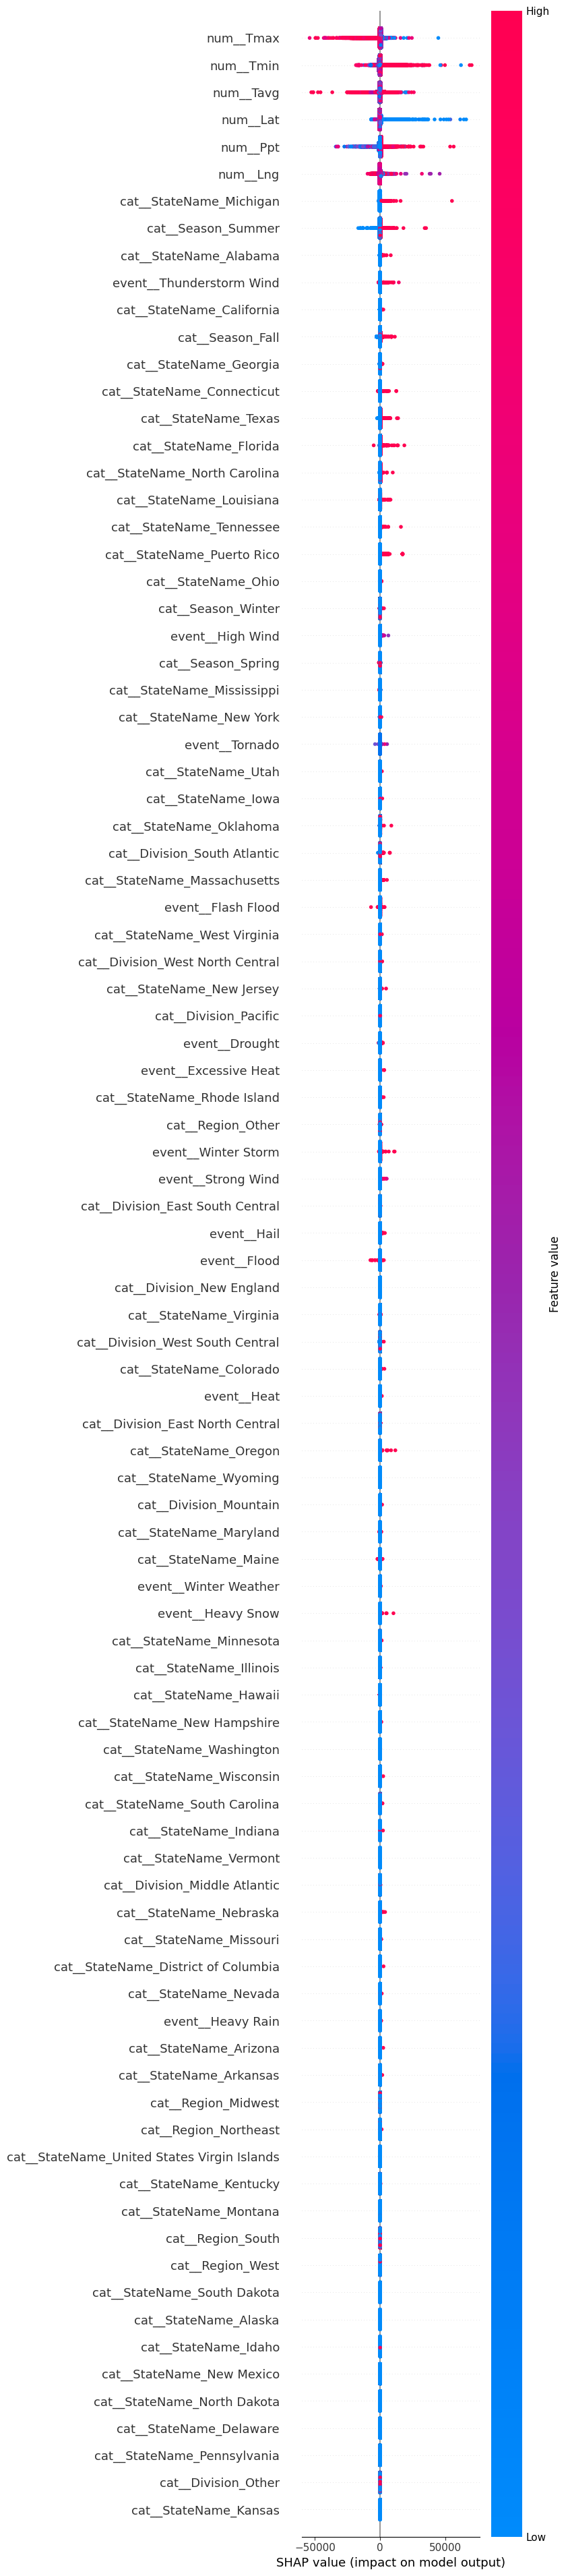

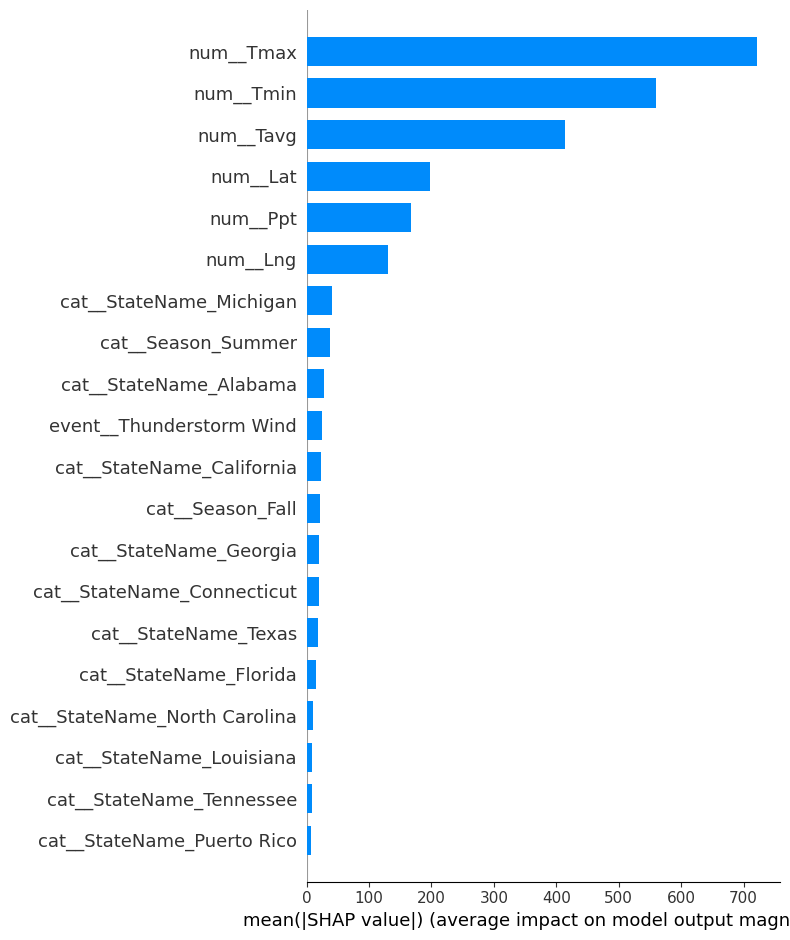

In [ ]:
explainer = shap.Explainer(model, X_train_transformed)

shap_values = explainer(X_val_transformed)

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
X_val_df = pd.DataFrame(X_val_transformed, columns=feature_names)

shap.summary_plot(shap_values, X_val_df, max_display=92)
shap.summary_plot(shap_values, X_val_df, plot_type="bar")


#### SHAP Analysis for the XGBRegressor Model

##### Feature Impact
SHAP values reveal that the most influential features are **temperature-related (`Tmax`, `Tmin`, `Tavg`, `Ppt`)** and **geographic variables (`Lat`, `Lng`)**, indicating that weather conditions and location strongly affect predictions. Most other features have a significantly lower impact.

##### Conclusion
This analysis emphasizes the **strong predictive power of weather-related variables** over administrative classifications. Removing low-impact categorical features and refining the model’s feature set may improve efficiency. 

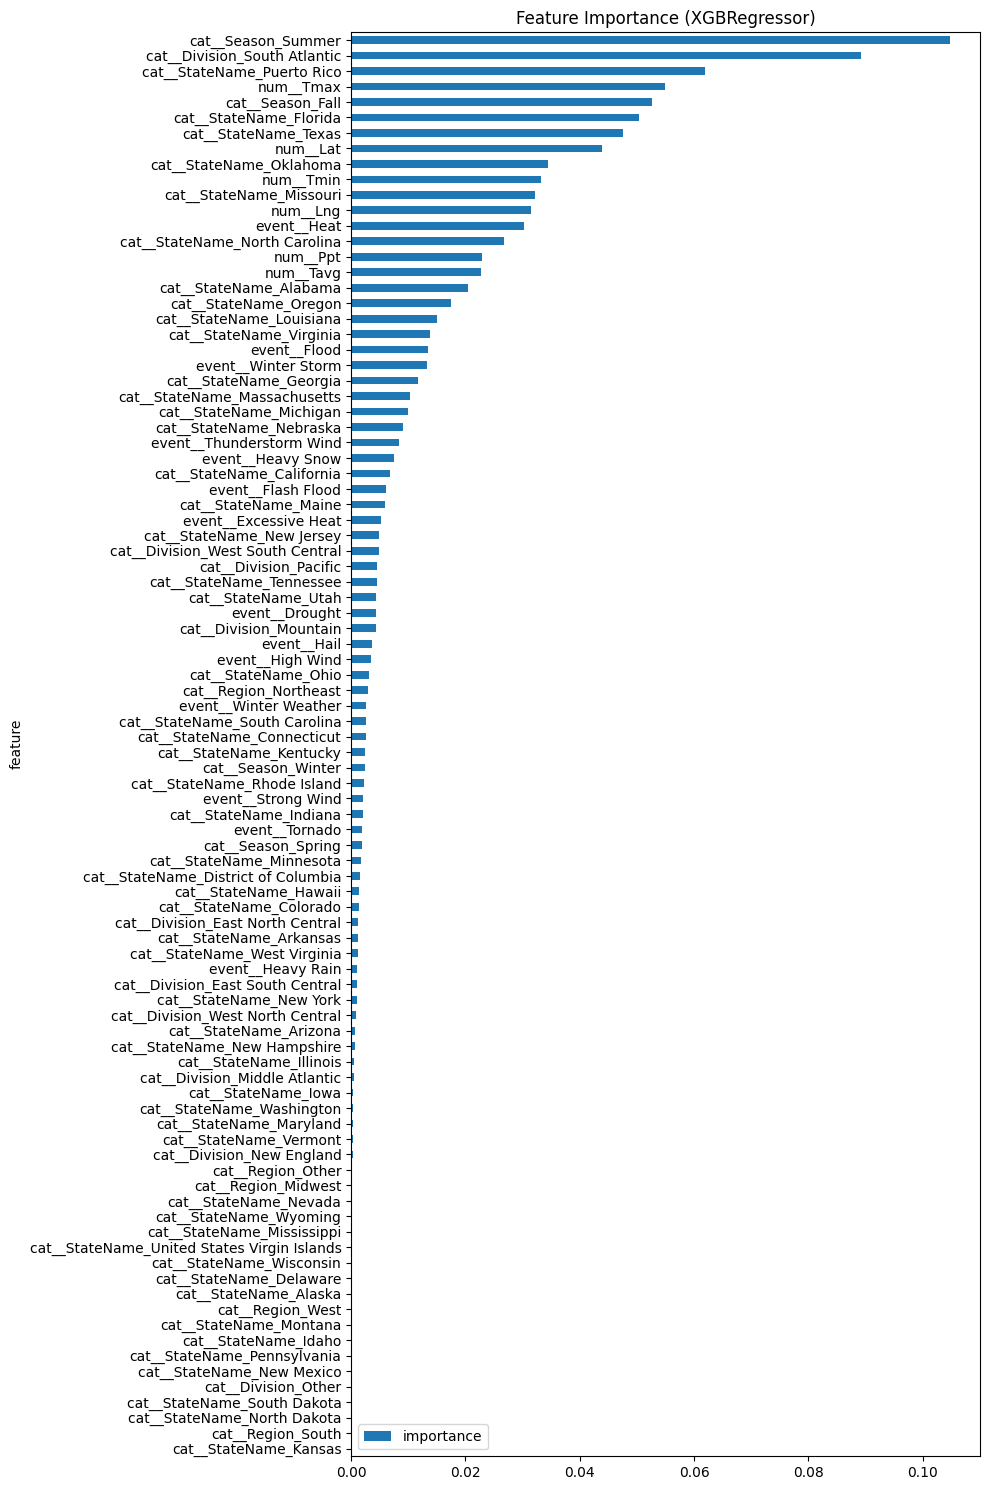

In [ ]:
importances = model.feature_importances_

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

importance_df.plot(kind='barh', x='feature', y='importance', figsize=(10, 15))
plt.title("Feature Importance (XGBRegressor)")
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

#### Feature Importance Analysis (XGBRegressor)

##### **Top Influential Features**
- **Seasonal & Geographic Factors:** `cat_Season_Summer`, `cat_Season_Fall`, `num_Tmax`, and `num_Tmin` indicate **weather-and-season-related trends** have a strong impact.
- **Location-Based Features:** `cat_Division_SouthAtlantic`, `cat_StateName_PuertoRico`, `cat_StateName_Florida`, `cat_StateName_Texas`, `num_Lat`, and `num_Lng` suggest that **specific state and regional locations** contribute significantly.

##### **Least Impactful Features**
- The bottom **30 features** are primarily **state-level (`cat_StateName_`), division (`cat_Division_`), and region (`cat_Region_`) classifications**, implying that broader administrative categories have minimal influence.

##### **Conclusion**
The model relies heavily on **temperature and location**, while **state, division, and region features have less predictive power**. Further refinement in feature selection could improve efficiency and reduce redundancy.


### MLPRegressor - Interpretation and Analysis of Results
Now, we will explore the **interpretability of MLPRegressor**, examining how feature importance contributes to predictions. By analyzing the **most influential variables**, we can gain insights into which factors drive model decisions and improve transparency. This process helps refine feature selection, optimize model performance, and identify potential biases affecting predictions.

In [ ]:
df = pd.read_csv('../data/modelingData/modelingDataFrame.csv')
event_names = ['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood','Winter Weather', 
               'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
               'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow', 'Ice Storm', 
               'Thunderstorm Wind', 'Avalanche', 'Excessive Heat', 'Coastal Flood', 'Storm Surge/Tide', 
               'Sleet', 'Debris Flow', 'Winter Storm', 'Tropical Storm', 'Dust Storm', 'Drought', 
               'Blizzard', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat', 'Freezing Fog', 
               'High Surf', 'High Wind']

df = df[df['ValidDataFlag'] == 1]
df.shape
zero_percentages = {}

for col in event_names:
    if col in df.columns:
        zero_count = (df[col] == 0).sum()
        total_count = len(df)
        zero_percentage = (zero_count / total_count) * 100
        zero_percentages[col] = zero_percentage

zero_percentages_df = pd.DataFrame.from_dict(zero_percentages, orient='index', columns=['%_zero'])
zero_percentages_df = zero_percentages_df.sort_values('%_zero', ascending=False)

selected_events_name = [
    col for col, perc in zero_percentages.items() if perc < 99.8
]

target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division']
event_features = [col for col in df.columns if col in selected_events_name]

X = df[numeric_features + categorical_features + event_features]

y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

event_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('event', event_transformer, event_features)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

pipeline.fit(X_train, y_train)

X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)

model_MLP = joblib.load('../models/model_MLP.pkl')

preds = model_MLP.predict(X_val_transformed.values)


  0%|          | 0/800 [00:00<?, ?it/s]

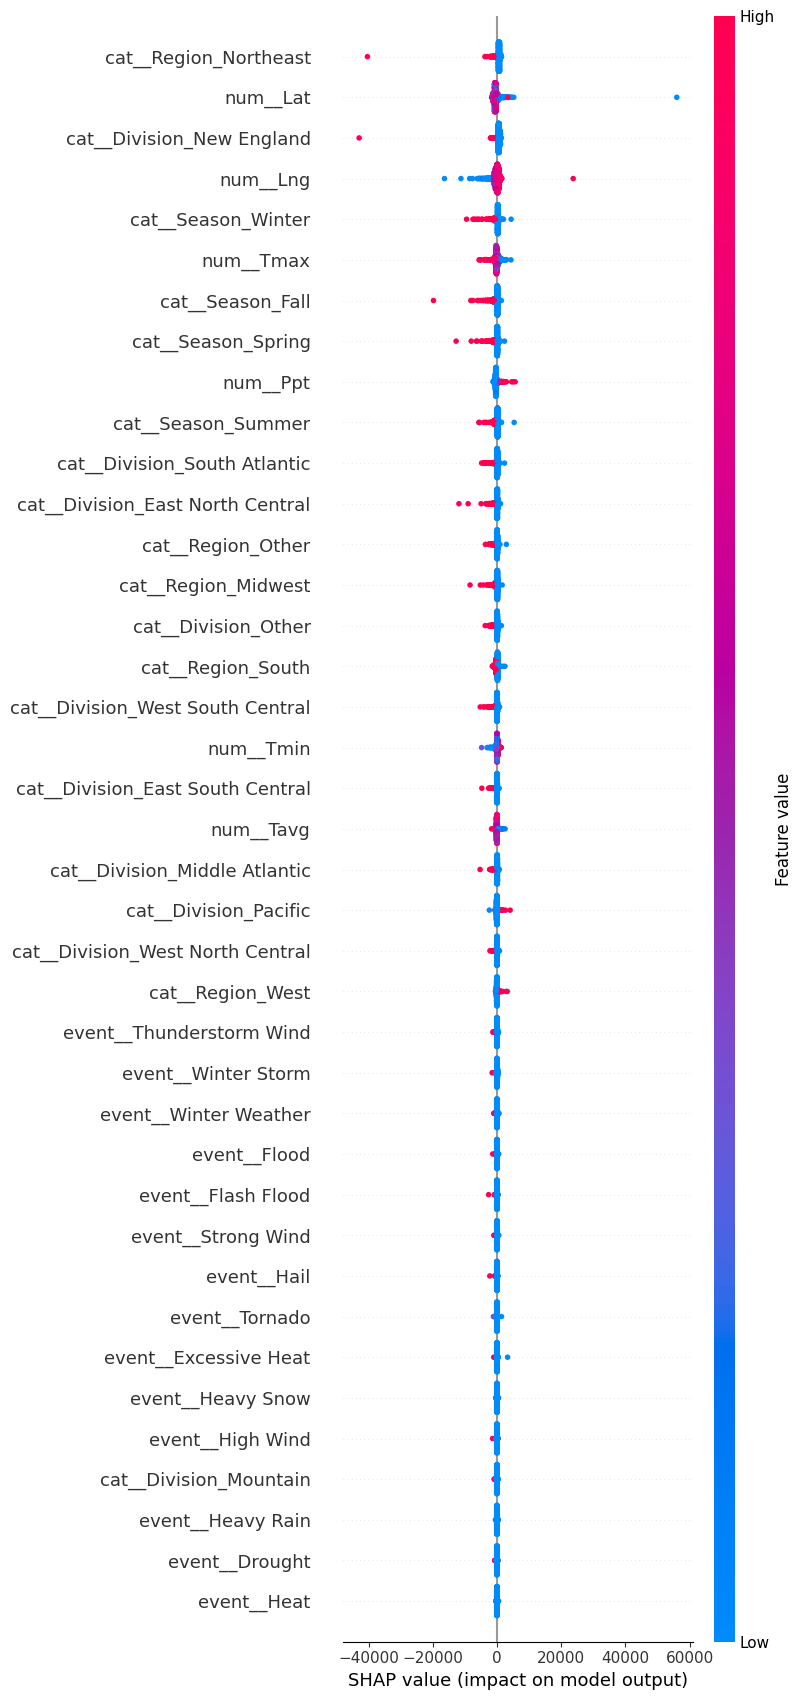

In [ ]:
explainer = shap.Explainer(model_MLP, X_train_transformed)

shap_values = explainer(X_val_transformed)

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
X_val_df = pd.DataFrame(X_val_transformed, columns=feature_names)

shap.summary_plot(shap_values, X_val_df, max_display=92)

#### SHAP Feature Importance Analysis of MLPRegressor

##### Key Influential Features
SHAP analysis highlights the **most impactful features** in the model:
- **Geographic factors:** `cat_Region_NorthEast`, `num_Lat`, `num_Lng`, `cat_Division_NewEngland`, showing location plays a significant role.
- **Seasonal & Weather Features:** `cat_Season_Winter`, `cat_Season_Fall`, `cat_Season_Spring`, `num_Tmax`, `num_Ppt`, indicating that temperature and precipitation strongly influence predictions.

##### Least Influential Features
- The features with **lowest SHAP values** include `event_Heat`, `event_Drought`, `event_HeavyRain`, `event_HighWind`, `event_Heavy_Snow`, `event_ExtensiveHeat`, `event_Tornado`, and `cat_Division_Mountain`, suggesting that specific weather events have minimal predictive power in this model.

##### Conclusion
The model relies **heavily on geographic and seasonal indicators**, with **weather events contributing minimally**. Refining feature selection by reducing less impactful event-related predictors may improve efficiency and accuracy.

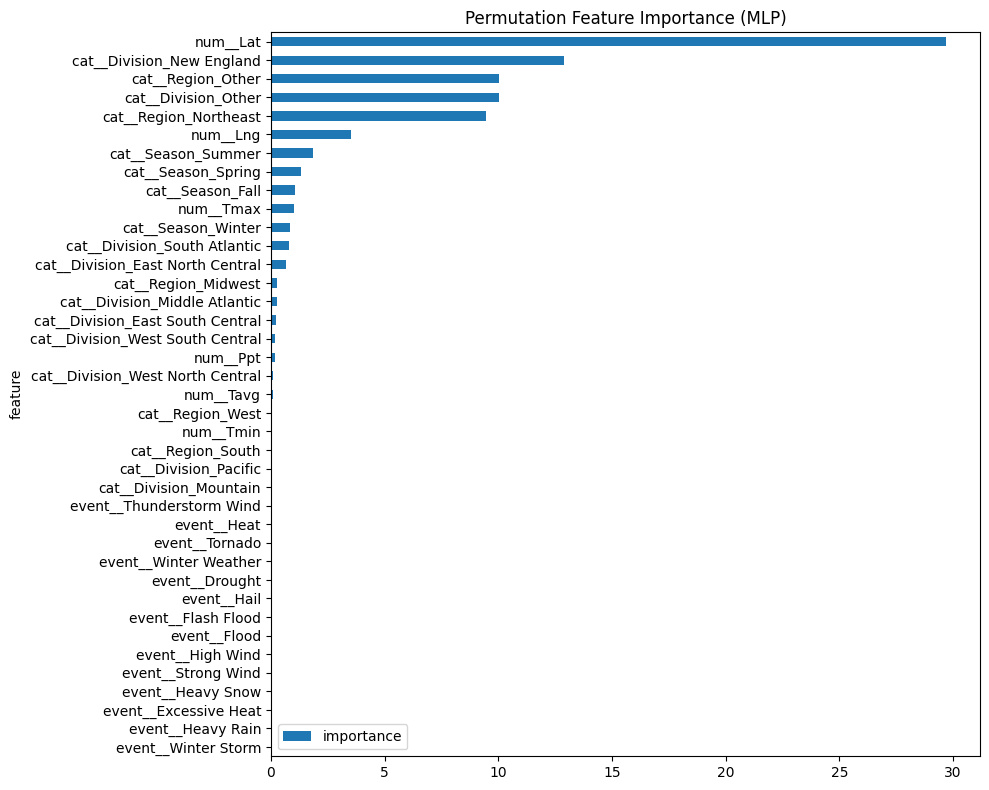

In [ ]:
result = permutation_importance(model_MLP, X_val_transformed, y_val, n_repeats=5, random_state=42, n_jobs=1)

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

importance_df.plot(kind='barh', x='feature', y='importance', figsize=(10, 8))
plt.title("Permutation Feature Importance (MLP)")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


#### MLP Model Permutation Importance Analysis

##### **Top Features:**
  - **num_Lat** has the highest importance, indicating strong predictive influence.
  - **cat_Division_New England, cat_Region_Other, cat_Division_Other, cat_Region_Northeast** follow, suggesting moderate impact.
  - Most categorical features (`enet_Winter Storm`, `event_Heavy Rain`, `event_Excessive Heat`, etc.) have small importance, implying lesser influence.

##### **Conclusion**
The feature importance analysis highlights **num_Lat** as the most significant predictor, suggesting that geographic positioning plays a crucial role in the model's performance. **Regional and division-based categorical features**, such as **cat_Division_New England** and **cat_Region_Northeast**, show moderate influence, indicating that broad geographic classifications contribute meaningfully to predictions. However, most **event-related categorical features** (e.g., `event_Winter Storm`, `event_Heavy Rain`, `event_Excessive Heat`) have **low importance**, implying that extreme weather events may not be strong predictors in the current model setup. 

### TabNet - Interpretation and Analysis of Results

In [ ]:
event_names = ['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood','Winter Weather', 
               'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
               'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow', 'Ice Storm', 
               'Thunderstorm Wind', 'Avalanche', 'Excessive Heat', 'Coastal Flood', 'Storm Surge/Tide', 
               'Sleet', 'Debris Flow', 'Winter Storm', 'Tropical Storm', 'Dust Storm', 'Drought', 
               'Blizzard', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat', 'Freezing Fog', 
               'High Surf', 'High Wind']

In [ ]:
df = df[df['ValidDataFlag'] == 1]
df = df[~df['Year'].isin([2015, 2016, 2017])]

zero_percentages = {}

for col in event_names:
    if col in df.columns:
        zero_count = (df[col] == 0).sum()
        total_count = len(df)
        zero_percentage = (zero_count / total_count) * 100
        zero_percentages[col] = zero_percentage

zero_percentages_df = pd.DataFrame.from_dict(zero_percentages, orient='index', columns=['%_zero'])
zero_percentages_df = zero_percentages_df.sort_values('%_zero', ascending=False)

selected_events_name = [
    col for col, perc in zero_percentages.items() if perc < 99.8
]

target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division', 'Month', 'StateName', 'CountyName']
event_features = [col for col in df.columns if col in selected_events_name]

X = df[numeric_features + categorical_features + event_features]
y = df[target]

X_encoded = X.copy()
for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))


X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [ ]:
model_TabNet = TabNetRegressor()
model_TabNet.load_model('../models/tabnet_model.zip')
preds = model_TabNet.predict(X_test.values)

c:\Users\olenk\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning:

Device used : cpu



In [ ]:
explain_matrix, masks = model_TabNet.explain(X_test.values)
feature_importance = np.mean(masks[0], axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

In [ ]:
feature_importance_df.head(5)

,feature,importance
22,Tornado,0.905317
3,Ppt,0.093306
11,CountyName,0.001377
0,Tmin,0.000000
14,Heavy Rain,0.000000


##### RMSE analysis per State

In [ ]:
state_le = LabelEncoder()
state_le.fit(X['StateName'].astype(str))

state_names = state_le.inverse_transform(X_test['StateName'].values)

In [ ]:
y_pred = model_TabNet.predict(X_test.values)

results_df = pd.DataFrame({
    'state': state_names,
    'y_true': y_test.values.flatten(),
    'y_pred': y_pred.flatten()
})

state_rmse = results_df.groupby('state').apply(lambda x: mean_squared_error(x['y_true'], x['y_pred'], squared=False)).reset_index()
state_rmse.columns = ['state', 'rmse']

display(state_rmse.sort_values(by='rmse').reset_index(drop=True))

,state,rmse
0,Wyoming,88.786033
1,South Dakota,114.264517
2,North Dakota,137.617440
3,New Mexico,163.164645
4,Montana,243.634474
5,Hawaii,283.975292
6,Minnesota,344.310130
7,Indiana,363.124483
8,Kansas,399.198023
9,Nevada,418.368477


As observed from the two tables above, there are significant differences between the individual states, and we would now like to examine them in greater detail. We will continue our analysis using the model from version 1.

In [ ]:
state_le = LabelEncoder()
state_le.fit(X['CountyName'].astype(str))

county_names = state_le.inverse_transform(X_test['CountyName'].values)

y_pred = model_TabNet.predict(X_test.values)

results_df = pd.DataFrame({
    'county': county_names,
    'y_true': y_test.values.flatten(),
    'y_pred': y_pred.flatten()
})

county_rmse = results_df.groupby('county').apply(lambda x: mean_squared_error(x['y_true'], x['y_pred'], squared=False)).reset_index()
county_rmse.columns = ['county', 'rmse']

display(county_rmse.sort_values(by='rmse').reset_index(drop=True))

,county,rmse
0,Geary,50.122195
1,Moniteau,51.503167
2,Oglethorpe,51.520566
3,Rawlins,52.574169
4,Nolan,53.771529
...,...,...
1087,Arecibo,12400.186847
1088,Bexar,12403.481472
1089,Oklahoma,16117.510213
1090,Mayagüez,25013.326898


In [ ]:
fips_lookup = df[['CountyName', 'Fips']].drop_duplicates()
county_rmse = county_rmse.merge(fips_lookup, left_on='county', right_on='CountyName', how='right')
county_rmse = county_rmse.drop(columns=['CountyName'])
display(county_rmse.head())

,county,rmse,Fips
0,Autauga,315.463842,1001
1,Baldwin,520.425824,1003
2,Blount,248.248212,1009
3,Butler,284.743544,1013
4,Calhoun,1185.539954,1015


In [11]:
uscounties = pd.read_csv('../data/population_data/uscounties.csv')

In [ ]:
fips_lookup = uscounties[['county', 'county_fips', 'state_name', 'state_id']].drop_duplicates()
fips_lookup.shape

(3144, 4)

In [ ]:
full_data = fips_lookup.merge(county_rmse,
                              left_on="county_fips", 
                              right_on="Fips",
                              how="left")

In [ ]:
full_data

,county_x,county_fips,state_name,state_id,county_y,rmse,Fips
0,Los Angeles,6037,California,CA,Los angeles,2504.471975,6037.0
1,Cook,17031,Illinois,IL,Cook,1736.626155,17031.0
2,Harris,48201,Texas,TX,Harris,2390.180852,48201.0
3,Maricopa,4013,Arizona,AZ,Maricopa,1327.823272,4013.0
4,San Diego,6073,California,CA,San diego,1267.217889,6073.0
...,...,...,...,...,...,...,...
3139,Blaine,31009,Nebraska,NE,NaN,NaN,NaN
3140,King,48269,Texas,TX,NaN,NaN,NaN
3141,Loving,48301,Texas,TX,Loving,55.407063,48301.0
3142,Kenedy,48261,Texas,TX,NaN,NaN,NaN


In [ ]:
full_data.drop(columns=['county_y', 'Fips'], inplace=True)
full_data['county_fips'] = full_data['county_fips'].astype(str).str.zfill(5)
full_data = full_data.rename(columns={'county_x': 'county_name'})

In [ ]:
max_value = full_data['rmse'].max()

In [ ]:
draw_map(full_data, "County RMSE by County", max_value)

In [ ]:
draw_map_for_state(full_data,
                   title="RMSE in Wyoming",
                   max_value=max_value,
                   state_fips="56")

In [ ]:
draw_map_for_state(full_data,
                   title="RMSE in Pennsylvania",
                   max_value=max_value,
                   state_fips="42")

In [ ]:
draw_map_for_state(full_data,
                   title="RMSE in Florida",
                   max_value=max_value,
                   state_fips="12")

In [ ]:
summary_list = []

for state in selected_states:
    summary = calculate_state_summary(df_merged, state)
    
    summary_list.append({
        'State': summary['state_name'],
        'Mean RMSE': round(summary['mean_rmse'], 2),
        'Max RMSE': round(summary['max_rmse'], 2),
        'Min RMSE': round(summary['min_rmse'], 2),
        'Total Number of Counties': summary['total_counties'],
        'Counties Not Taken Into Modeling (NaN RMSE)': summary['counties_with_nan_rmse'],
        'Percentage of Counties Not Taken Into Modeling': round(summary['percent_nan_rmse'], 2),
        'Total Population': summary['total_population'],
        'Population per County': int(summary['population_per_county']) 
    })

summary_df = pd.DataFrame(summary_list)

summary_df[['Mean RMSE', 'Max RMSE', 'Min RMSE', 'Percentage of Counties Not Taken Into Modeling']] = \
    summary_df[['Mean RMSE', 'Max RMSE', 'Min RMSE', 'Percentage of Counties Not Taken Into Modeling']].applymap(lambda x: round(x, 2))

display(summary_df)

,State,Mean RMSE,Max RMSE,Min RMSE,Total Number of Counties,Counties Not Taken Into Modeling (NaN RMSE),Percentage of Counties Not Taken Into Modeling,Total Population,Population per County
0,Wyoming,208.97,699.57,68.88,23,14,60.87,579761,25207
1,Pennsylvania,676.56,7332.70,167.73,67,16,23.88,12986518,193828
2,Florida,1499.11,9462.02,113.23,67,11,16.42,21928881,327296


### Summary of Model Performance for Wyoming, Pennsylvania, and Florida
#### Observations:
Wyoming outperforms the other two states, with a relatively low mean RMSE of 208.97 and a modest maximum RMSE of 699.57. The model performs best here, despite the high percentage of counties (60.87%) being excluded due to missing data (NaN RMSE). The state has a smaller population, which could simplify the prediction task and contribute to the better performance.

Pennsylvania shows a moderate performance, with a mean RMSE of 676.56, much higher than Wyoming's, but much lower than Florida's. It also has a higher number of counties (67), and 23.88% of them were excluded due to NaN RMSE. The population per county is significantly higher than in Wyoming, which may present additional challenges for the model, such as more complex patterns in data that the model struggled to capture.

Florida presents the worst performance with a mean RMSE of 1499.11, indicating that the model has a significant margin of error. The maximum RMSE of 9,462.02 suggests that the model may have struggled with certain counties, possibly due to data complexities or extreme weather events not captured well in the model. Although only 16.42% of counties were excluded from modeling, the high population per county (327,296) and possibly more diverse geographical and environmental factors could have contributed to the poor performance.

#### Speculation on the Causes:
Wyoming: The relatively small population and fewer counties likely make it easier for the model to find patterns and generalize across the state. Additionally, Wyoming's more uniform and predictable climate conditions (for example, fewer natural disasters) may result in fewer complexities, allowing the model to perform better.

Pennsylvania: With a larger and more diverse population, more counties, and varied climatic conditions, the model faces more complexity. The higher mean RMSE and exclusion of some counties may point to more localized factors, such as differing weather patterns across regions, that the model couldn't capture effectively.

Florida: Florida’s larger population per county and the state's susceptibility to extreme weather events (e.g., hurricanes) may have contributed to the model's poor performance. Florida also has a diverse geography with coastal and inland areas, which could cause challenges for a model trained on generalized data, especially when predicting power outages. The extreme RMSE values suggest that outliers or extreme events might be poorly represented in the model's predictions.

In conclusion, the model’s performance varies significantly across states due to the size and complexity of the data, as well as the environmental and demographic characteristics of each state. Wyoming’s more uniform conditions likely make it easier for the model to succeed, while Pennsylvania and Florida present more challenges due to their larger and more varied populations, as well as extreme weather patterns.

__________________________________________________________________________________

### TabNet - Interpretation and Analysis of Results for State-Specific Models
Given that previous models struggled with the complexity and diversity of the data when trained on the entire USA, we have decided to take a more focused approach by building separate models for each state. This section will discuss the analysis and interpretation of the results from these state-specific models.

In [4]:
df = pd.read_csv('../data/modelingData/modelingDataFrame.csv')
df_folrida = df[df['StateName'] == 'Florida']

target = 'CustomersOut'

event_names = ['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood','Winter Weather', 
               'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
               'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow', 'Ice Storm', 
               'Thunderstorm Wind', 'Avalanche', 'Excessive Heat', 'Coastal Flood', 'Storm Surge/Tide', 
               'Sleet', 'Debris Flow', 'Winter Storm', 'Tropical Storm', 'Dust Storm', 'Drought', 
               'Blizzard', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat', 'Freezing Fog', 
               'High Surf', 'High Wind']

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division', 'Month', 'CountyName']
event_features = [col for col in df_folrida.columns if col in event_names]

X = df_folrida[numeric_features + categorical_features + event_features]
y = df_folrida[target]

X_encoded = X.copy()
for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

Q3 = np.percentile(y, 90)
Q1 = np.percentile(y, 10)
IQR = Q3 - Q1
upper_bound = Q3 + 1.0 * IQR
mask = (y <= upper_bound)

y_no_outliers = y[mask]
X_no_outliers = X_encoded[mask]

X_train_florida, X_test_florida, y_train_florida, y_test_florida = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

In [5]:
model_TabNet_florida = TabNetRegressor()
model_TabNet_florida.load_model('../models/model_TabNet_florida.zip')
preds = model_TabNet_florida.predict(X_test_florida.values)

c:\Users\olenk\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [179]:
explain_matrix, masks = model_TabNet_florida.explain(X_test_florida.values)
feature_importance = np.mean(masks[0], axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_test_florida.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

In [181]:
feature_importance_df.head(10)

,feature,importance
4,Lat,0.085904
19,Frost/Freeze,0.064915
3,Ppt,0.063162
43,Freezing Fog,0.059852
32,Debris Flow,0.053171
29,Coastal Flood,0.051909
45,High Wind,0.050829
13,Flood,0.045772
38,Lightning,0.045763
12,Extreme Cold/Wind Chill,0.039924


In [8]:
state_le = LabelEncoder()
state_le.fit(X['CountyName'].astype(str))

county_names = state_le.inverse_transform(X_test_florida['CountyName'].values)

y_pred = model_TabNet_florida.predict(X_test_florida.values)

results_df = pd.DataFrame({
    'county': county_names,
    'y_true': y_test_florida.values.flatten(),
    'y_pred': y_pred.flatten()
})

county_rmse = results_df.groupby('county').apply(lambda x: mean_squared_error(x['y_true'], x['y_pred'], squared=False)).reset_index()
county_rmse.columns = ['county', 'rmse']

display(county_rmse.sort_values(by='rmse').reset_index(drop=True))

,county,rmse
0,Liberty,27.501707
1,Lafayette,28.861181
2,Suwannee,30.662910
3,Baker,30.992714
4,Santa rosa,30.999271
...,...,...
62,Hillsborough,78.986705
63,Palm beach,82.212200
64,Pinellas,82.561196
65,Broward,101.025283


In [9]:
fips_lookup = df[['CountyName', 'Fips']].drop_duplicates()
county_rmse = county_rmse.merge(fips_lookup, left_on='county', right_on='CountyName', how='right')
county_rmse = county_rmse.drop(columns=['CountyName'])

In [12]:
uscounties = pd.read_csv('../data/population_data/uscounties.csv')
fips_lookup = uscounties[['county', 'county_fips', 'state_name', 'state_id']].drop_duplicates()

In [13]:
full_data_florida = fips_lookup.merge(county_rmse,
                              left_on="county_fips", 
                              right_on="Fips",
                              how="left")

In [15]:
full_data_florida.drop(columns=['county_y', 'Fips'], inplace=True)
full_data_florida['county_fips'] = full_data_florida['county_fips'].astype(str).str.zfill(5)
full_data_florida = full_data_florida.rename(columns={'county_x': 'county_name'})

In [21]:
draw_map_for_state(full_data_florida,
                   title="RMSE in Florida (Florida State)",
                   max_value=15000,
                   state_fips="12")

#### Conclusions
Now, using a model trained specifically on data from Florida, we are observing a significant improvement. The model is now capturing features that were previously overlooked in the general model. The map above provides the clearest illustration of the magnitude of this enhancement. In conclusion, by modeling at the state level, we can achieve notably better results.

________________________________________________________________________________

### Sarimax - Interpretation and Analysis of Results

In [ ]:
df = pd.read_csv('../data/modelingData/modelingDataFrame.csv')

In [ ]:
shap.dependence_plot('feature_name', shap_values, sample_data)


#### Comparison and Interpretation of Models for Counties with Different Frequencies of Major Power Outages

- **(a)** County with a very high number of outages — *Waynesboro County, Virginia*  
- **(b)** County with a very low number of outages — *Suffolk County, New York*

We will evaluate how the models perform in these two contrasting scenarios, identify which variables are most important in each case, and analyze the differences in model behavior across the two counties.


In [ ]:
df_high_train, df_low_train, df_high_test, df_low_test = transform_df(df)

In [ ]:
model_low = SARIMAX(df_low_train['PercentCustomersOut'],
            exog=df_low_train.drop(columns='PercentCustomersOut'),
            order=(1, 0, 1), 
            seasonal_order=(0, 0, 0, 0),
            enforce_stationarity=False,
            enforce_invertibility=False)
model_high = SARIMAX(df_high_train['PercentCustomersOut'],
            exog=df_high_train.drop(columns='PercentCustomersOut'),
            order=(1, 0, 1), 
            seasonal_order=(0, 0, 0, 0),
            enforce_stationarity=False,
            enforce_invertibility=False)

results_low = model_low.fit(disp=False)
results_high = model_high.fit(disp=False)

forecast_results_high = results_high.get_forecast(steps=len(df_high_test), exog=df_high_test.drop(columns='PercentCustomersOut'))
forecast_high = forecast_results_high.predicted_mean
forecast_results_low = results_low.get_forecast(steps=len(df_low_test), exog=df_low_test.drop(columns='PercentCustomersOut'))
forecast_low = forecast_results_low.predicted_mean

In [ ]:
rmse_high = np.sqrt(mean_squared_error(df_high_test['PercentCustomersOut'], forecast_high))
print(f'RMSE for model_high: {rmse_high}')

RMSE for model_high: 40.91253721052622


In [ ]:
results_high.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     PercentCustomersOut   No. Observations:                 2922
Model:                SARIMAX(1, 0, 1)   Log Likelihood              -14978.601
Date:                 Sun, 27 Apr 2025   AIC                          30007.201
Time:                         21:27:57   BIC                          30156.685
Sample:                     01-01-2015   HQIC                         30061.044
                          - 12-31-2022                                         
Covariance Type:                   opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Tmin               -562.5902   1060.228     -0.531      0.596   -2640.599    1515.419
Tmax               -562.7145   1060.223     -0.531      0.596   -2640.714    1515.285
Tavg               1125.8482   2120.447      0.531      0.595   -3030.151    5281.848
Ppt                   0.7243      0.118      6.139      0.000       0.493       0.956
Flood             -4.619e-11        nan        nan        nan         nan         nan
Winter Weather     1.481e-11   7.07e-08      0.000      1.000   -1.39e-07    1.39e-07
Heavy Rain        -1.406e-12    2.6e-08   -5.4e-05      1.000    -5.1e-08     5.1e-08
Strong Wind       -2.456e-10   7.49e-09     -0.033      0.974   -1.49e-08    1.44e-08
Flash Flood                0        nan        nan        nan         nan         nan
Heavy Snow                 0   2.21e-12          0      1.000   -4.32e-12    4.32e-12
Thunderstorm Wind          0         -0        nan        nan           0           0
Excessive Heat             0         -0        nan        nan           0           0
Winter Storm               0         -0        nan        nan           0           0
Drought                    0         -0        nan        nan           0           0
Tornado                    0         -0        nan        nan           0           0
Hail                       0         -0        nan        nan           0           0
Heat                       0         -0        nan        nan           0           0
High Wind                  0         -0        nan        nan           0           0
Season_Fall          23.6607      4.044      5.851      0.000      15.735      31.586
Season_Spring        23.7310      4.378      5.420      0.000      15.150      32.312
Season_Summer        24.2419      4.773      5.078      0.000      14.886      33.598
Season_Winter        24.4250      3.830      6.377      0.000      16.918      31.932
ar.L1                 0.0271      0.121      0.224      0.823      -0.210       0.264
ma.L1                 0.1267      0.120      1.056      0.291      -0.108       0.362
sigma2             1671.9472    125.321     13.341      0.000    1426.322    1917.572
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               400.99
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.76
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.3e+57. Standard errors may be unstable.
"""

### Model Summary

#### 1. **Statistically Significant Variables**:
The following variables have a **statistically significant** impact on the model, as indicated by their p-values (p < 0.05):

- **Ppt (Precipitation)**: The coefficient for precipitation is 0.7243, and it has a p-value of 0.000
  
- **Seasonal Variables**:
  - **Season_Fall**: Coefficient = 23.6607, p-value = 0.000. Fall season significantly affects the power outage predictions.
  - **Season_Spring**: Coefficient = 23.7310, p-value = 0.000. Spring season also significantly contributes to predicting power outages.
  - **Season_Summer**: Coefficient = 24.2419, p-value = 0.000. Summer season has a substantial effect.
  - **Season_Winter**: Coefficient = 24.4250, p-value = 0.000. Winter season is another significant factor.

#### 2. **Insignificant Variables**:
Several variables appear to have **no significant impact** on the model

- **Temperature-related variables** (Tmin, Tmax, Tavg): Despite their relatively high coefficients, these variables have p-values above 0.05
  
- **Weather events** (Flood, Winter Weather, Heavy Rain, Strong Wind, Flash Flood, etc.): Many weather-related variables have p-values of 1.000 or nan values

#### 4. **Overall Conclusions**:
- **Seasonal effects** and **precipitation** are the main drivers of power outages in this model. The high coefficients and significant p-values for seasonal variables indicate that the time of year plays a major role in predicting power outages.


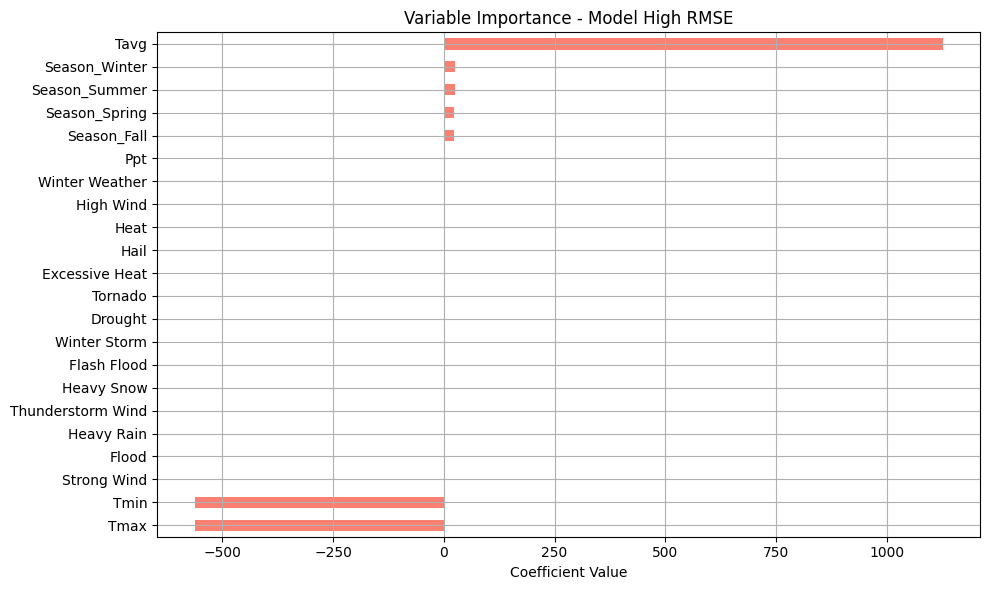

In [ ]:
coefficients_high = results_high.params.drop(['ar.L1', 'ma.L1', 'sigma2'])

plt.figure(figsize=(10, 6))
coefficients_high.sort_values().plot(kind='barh', color='salmon')
plt.title('Variable Importance - Model High RMSE')
plt.xlabel('Coefficient Value')
plt.grid(True)
plt.tight_layout()
plt.show()

As we can observe, seasonal variables are important. Temperature appears to have the greatest influence on the model. However, from the summary, we can see that it is not statistically significant. Additionally, all event-related variables show no meaningful impact on the model

In [ ]:
rmse_low = np.sqrt(mean_squared_error(df_low_test['PercentCustomersOut'], forecast_low))
print(f'RMSE for model_low: {rmse_low}')

RMSE for model_low: 0.08001893674110065


In [ ]:
results_low.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     PercentCustomersOut   No. Observations:                 2924
Model:                SARIMAX(1, 0, 1)   Log Likelihood               -2220.074
Date:                 Sun, 27 Apr 2025   AIC                           4490.147
Time:                         21:31:19   BIC                           4639.648
Sample:                     01-01-2015   HQIC                          4543.995
                          - 01-02-2023                                         
Covariance Type:                   opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Tmin                -40.0714     41.982     -0.954      0.340    -122.356      42.213
Tmax                -40.0722     41.980     -0.955      0.340    -122.352      42.208
Tavg                 80.1433     83.966      0.954      0.340     -84.426     244.713
Ppt                   0.0042      0.003      1.550      0.121      -0.001       0.009
Flood                 0.0973      0.212      0.460      0.646      -0.317       0.512
Winter Weather       -0.0161      0.641     -0.025      0.980      -1.273       1.241
Heavy Rain         5.928e-11   3.76e-07      0.000      1.000   -7.37e-07    7.37e-07
Strong Wind           0.0005      0.010      0.047      0.962      -0.020       0.021
Flash Flood           0.0538      0.494      0.109      0.913      -0.915       1.022
Heavy Snow            0.0653      0.288      0.226      0.821      -0.500       0.630
Thunderstorm Wind    -0.0001      0.002     -0.069      0.945      -0.004       0.004
Excessive Heat       -0.1281      1.593     -0.080      0.936      -3.251       2.995
Winter Storm         -0.0282      0.257     -0.110      0.913      -0.533       0.476
Drought              -0.0259      1.471     -0.018      0.986      -2.909       2.857
Tornado              -0.0007      0.521     -0.001      0.999      -1.021       1.020
Hail                 -0.0742      0.150     -0.495      0.620      -0.368       0.219
Heat              -7.209e-15        nan        nan        nan         nan         nan
High Wind             0.0004      0.004      0.112      0.911      -0.007       0.008
Season_Fall           0.0211      0.381      0.055      0.956      -0.727       0.769
Season_Spring         0.0180      0.619      0.029      0.977      -1.195       1.231
Season_Summer         0.1351      0.433      0.312      0.755      -0.714       0.984
Season_Winter         0.0114      0.446      0.026      0.980      -0.862       0.885
ar.L1                 0.7021      0.008     87.064      0.000       0.686       0.718
ma.L1                 0.1141      0.023      4.879      0.000       0.068       0.160
sigma2                0.2669      0.002    127.547      0.000       0.263       0.271
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):         710929672.90
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):              99.62   Skew:                            46.98
Prob(H) (two-sided):                  0.00   Kurtosis:                      2417.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.05e+25. Standard errors may be unstable.
"""

### Model Summary

#### 1. **Statistically Significant Variables**:
In this model, **none of the variables** are statistically significant (p-value < 0.05), as most variables have p-values greater than 0.05. The variables that are close to significance or have the highest coefficients include:

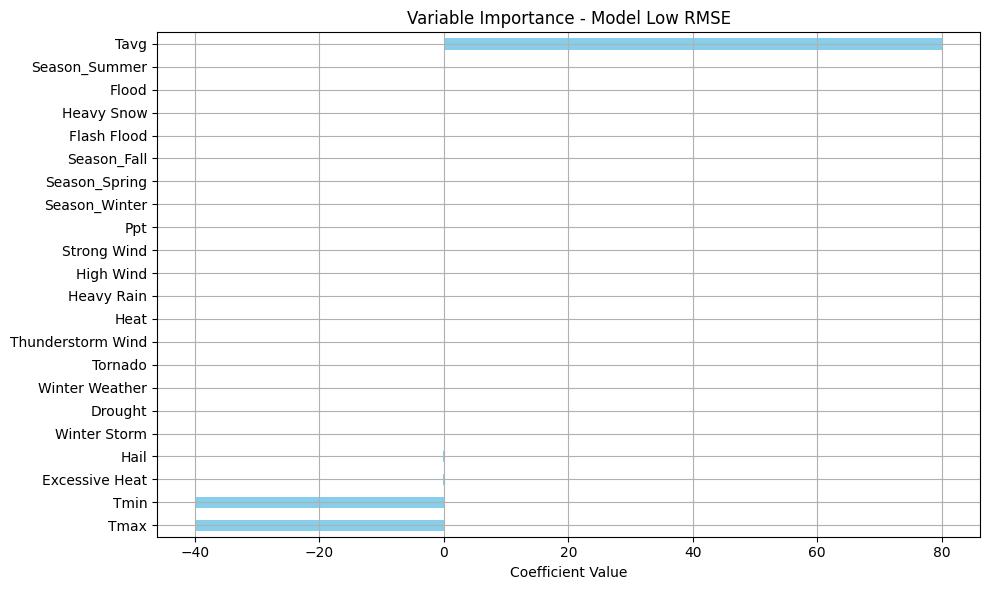

In [ ]:
coefficients_low = results_low.params.drop(['ar.L1', 'ma.L1', 'sigma2']) 

plt.figure(figsize=(10, 6))
coefficients_low.sort_values().plot(kind='barh', color='skyblue')
plt.title('Variable Importance - Model Low RMSE')
plt.xlabel('Coefficient Value')
plt.grid(True)
plt.tight_layout()
plt.show()


As we can observe, average temperature appears to have the greatest influence on the model. However, from the summary, we can see that it is not statistically significant. Additionally, all event-related variables show no meaningful impact on the model

### What Could Have Influenced the Differences in Modeling?

#### 1. **Data Variability Across Different Counties**:
Counties with frequent large power outages may cause the model to have higher forecasting errors (higher RMSE), as SARIMAX models struggle to predict large, unpredictable events. On the other hand, counties with rare outages might result in more stable model predictions, leading to lower errors (lower RMSE).

#### 2. **Scale and Frequency of Events**:
In regions with frequent extreme weather events (such as tornadoes and storms), SARIMAX models may face difficulties in forecasting such rare but significant occurrences, leading to higher RMSE values. In contrast, in less dynamic regions, the model might be more stable and accurate in its predictions.

### Conclusions: The Model Depends on the County
Models are not universal and should be tailored to the specific data characteristics of each county. This suggests that the success of the model largely depends on the regional characteristics, such as the frequency and severity of events, which can significantly affect the quality and accuracy of forecasts.
